In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from logger import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common_functions import NPCL, common
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize'] = (20, 5)
npcl_obj = NPCL()
common_obj  = common()
np.set_printoptions(suppress=True, precision=8)


In [2]:
import os
from logger import logger
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class testing:
    
    def add_lags(self, dff, target_col, large_data= False):
        try:
            # target_map = dff['consumed_unit'].to_dict()
            target_map = dff[target_col].to_dict()

            # 1 Hour, 2 Hours, 6 Hours
            dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
            dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
            dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
            # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
            # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
            dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
            # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
            # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
            # dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

            # if large_data:
            # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
            # dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
            # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
                # logger.info(f" lags added for large data")
            #     return dff
            # else:
            


            # logger.info(f"lags added")
            return dff
        
        except KeyError as e:
            logger.error(f"Error: {e}. 'consumed_unit' column not found in the DataFrame.",exc_info=True)
        except Exception as ex:
            logger.error(f"An unexpected error occurred: {ex}",exc_info= True)


    def create_features(self,hourly_data,lagre_data= False):
        try:
            hourly_data = hourly_data.copy()
            # Check if the index is in datetime format
            if not isinstance(hourly_data.index, pd.DatetimeIndex):
                hourly_data.index = pd.to_datetime(hourly_data.index)
            
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['day'] = hourly_data.index.day
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            hourly_data['dayofyear'] = hourly_data.index.dayofyear
            hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
            # hourly_data['holiday'] = 0
            # # if lagre_data:
            # hourly_data['month'] = hourly_data.index.month
            # hourly_data['quarter'] = hourly_data.index.quarter
            # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            # hourly_data['year'] = hourly_data.index.year
        
            return hourly_data

        except Exception as e:
            logger.info(f"error in feature creation: {e}",exc_info= True)

    def scaling_layer(self,dataset,target_variable= "Load_kW"):
        try:
            scaler = MinMaxScaler()
            # Exclude the "Load_kW" column from features to normalize
            features_to_normalize = [col for col in dataset.columns if col != target_variable]
        
            dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
            with open('saved_model/minmax_scaler_all_feeders.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            return dataset
        
        except Exception as e:
            logger.error(f"error in scaling: {e}",exc_info= True) 

    def data_split_function(self,dataset, target_variable= "Load_kW"):
        """
            Splits the given dataset into training and testing sets, separating features and the target variable.

            Args:
                dataset (pandas.DataFrame): The dataset containing both features and the target variable.
                target_variable (str): The name of the column representing the target variable to be predicted. Default is 'Load_kW'.

            Returns:
                X_train (pandas.DataFrame): Training set features.
                X_test (pandas.DataFrame): Testing set features.
                y_train (pandas.Series): Training set target variable.
                y_test (pandas.Series): Testing set target variable.
            
            Raises:
                Exception: If there's an issue during the data split, an error message is logged.

            Example:
                >>> df = pd.DataFrame({...})
                >>> X_train, X_test, y_train, y_test = obj.data_split(df, target_variable="Load_kW")
        """
        try:
            n = len(dataset)
            train_df = dataset[0:int(n*0.9)]
            test_df = dataset[int(n*0.9):]
            train_dataset, test_dataset = train_df.copy(),test_df.copy() #,val_df.copy()
            # train_labels = train_features.pop(target_variable)
            # test_labels = test_features.pop(target_variable)
            
            # print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            # print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"data split done")
            # logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            # logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"train_features shape:{train_dataset.shape}")
            logger.info(f"test_features shape:{test_dataset.shape}")

            return train_dataset,test_dataset
            # return train_features,test_features,train_labels, test_labels
        
        except Exception as e:
            logger.error(f"error in split: {e}",exc_info=True)


    def model_trainer(self, train_dataset, target_variable, random_state=True, model_name=None):
        try:
            # noramlizing data
            dataset_scalled = self.scaling_layer(dataset=train_dataset)

            # Split the dataset into training and test sets using train test split function with randomizing data
            if random_state:            
                # dataset_labels = dataset_scalled.pop(target_variable)
                train_features, test_features, train_label, test_label = self.data_split(dataset_scalled)    
            
            else:    
                # Split the dataset into training and test sets using custom data split function without randomizing data
                train_features, test_features = self.data_split_function(dataset=dataset_scalled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)
            
            os.makedirs('saved_model/test', exist_ok=True)
            if model_name == "RFR":
                # Step 4: Initialize the RandomForestRegressor model
                model= self.random_forest_regressor(train_features=train_features,
                                                    train_label=train_label)
                logger.info(f"model trained : RandomForestRegressor")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                
                # Save the model to a file
                # joblib.dump(model, 'saved_model/RandomForestRegressor_model.pkl'


            if model_name == "XGboost":
                model = self.XGboost_model(train_features= train_features,
                                        train_label= train_label)
                logger.info(f"model trained : XGboost")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                # Save the model to a file
                # joblib.dump(model, 'saved_model/XGboost_model.pkl')            
                        
            files = os.listdir("saved_model/test")
            if len(files) == 0:
                model_version = 1  # Start at version 1 if no files are present
            else:
                model_version = max([int(i.split(".")[1]) for i in files if i.split(".")[1].isdigit()]) + 1
            joblib.dump(model, f"saved_model/test/{model_name}.{model_version}.pkl")
            # model_version=max([int(i) for i in range(len(os.listdir("saved_model/test")+ [0])) ])+1
            # model.save(f"saved_model/test/{model_name}_1.{model_version}")
            return model
        except Exception as e:
            logger.error(f"error in model trainer: {e}",exc_info=True)

    def data_split(self, dataset, target_variable= "Load_kW"): 
        try:
            dataset_features = dataset.copy()
            dataset_label = dataset_features.pop(target_variable)
            # Split the dataset into training and test sets
            train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, random_state=42)
            logger.info(f"data split done")
            logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            return train_features, test_features, train_labels, test_labels

        except Exception as e:
            logger.error(f"error in data split: {e}",exc_info=True)  

    def random_forest_regressor(self, train_features, train_label):
        try:
            # model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tweak hyperparameters
            # model.fit(train_features,train_label)
            param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [10, 20, 30, 50, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'n_jobs': [-1]  # Use all cores for faster training
            }

            # Initialize the RandomForestRegressor model
            model = RandomForestRegressor(random_state=42)

            # Perform hyperparameter tuning using RandomizedSearchCV
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                            n_iter=10, cv=5, verbose=2, 
                                            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
            
            # Fit the RandomizedSearchCV to the data
            random_search.fit(train_features, train_label)
            
            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")
            
            # Train the model with the best parameters
            best_model = RandomForestRegressor(**best_params, random_state=42)
            best_model.fit(train_features, train_label)
            
            logger.info(f"Model trained: RandomForestRegressor with best parameters")
        
            return best_model
        
        except Exception as e:
            logger.error(f"error in random_forest_regressor: {e}", exc_info= True)
    def XGboost_model(self,train_features, train_label):
        try:
            xgb_model = XGBRegressor()
            xgb_model.fit(train_features, train_label)
            
            # Calculate and print model evaluation metrics for this sensor
            train_score = xgb_model.score(train_features, train_label)
            print(f"Initial Train Score {train_score}")
            
            # Perform hyperparameter tuning using RandomizedSearchCV
            param_grid = {
                    "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
                    "max_depth": [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
                    "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
                    "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "n_estimators": [200, 250, 300, 350,400, 450, 500],
                    # "max_depth": [3,5,10,15, 20, 25,30],
                    # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    }
            
            random_search = RandomizedSearchCV(xgb_model,
                                                param_distributions=param_grid,
                                                n_iter=5,
                                                scoring='neg_mean_squared_error',
                                                cv=5,
                                                random_state=100)

            # Fit the RandomizedSearchCV to the data
            # random_search.fit(X_train, y_train)
            random_search.fit(train_features, train_label)

            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")

            # Train the model with the best parameters
            best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            subsample=best_params['subsample'],
                                            colsample_bytree=best_params['colsample_bytree'],
                                            reg_alpha=best_params['reg_alpha'],
                                            base_score=0.5,
                                            booster='gbtree',
                                            # reg_lambda=best_params['reg_lambda'],
                                            objective='reg:squarederror')
            best_xgb_model.fit(train_features, train_label)

            # Evaluate the model on the test set
            test_score = best_xgb_model.score(train_features, train_label)
            print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
            return best_xgb_model
        except Exception as e:
            logger.info(f"error in XGboost: {e}",exc_info= True)


    def prediction(self,model, input_data, scoring=False, test_data= None,prediction= False):
        try:
            if prediction:
                scaler= self.scaler_value()

                input_data = scaler.transform(input_data)

            # Step 6: Make predictions
            y_pred = model.predict(input_data)
            if y_pred is not None:
                logger.info("predition_succesful")

            if scoring :
                # Step 7: Evaluate the model
                rmse = sqrt(mean_squared_error(test_data, y_pred))
                print("\nModel Power Evaluation")
                print("Mean Squared Error (MSE):", mean_squared_error(test_data, y_pred))
                print("Mean Absolute Error (MAE):", mean_absolute_error(test_data, y_pred))
                print(f"Root Mean Squared Error (RMSE): {rmse}")
                print("R-squared:", r2_score(test_data, y_pred))
                logger.info(f"\nModel Evaluation")
                logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
                logger.info(f"Mean Squared Error (MSE): {mean_squared_error(test_data, y_pred)}")
                logger.info(f"Mean Absolute Error (MAE): {mean_absolute_error(test_data, y_pred)}")
                logger.info(f"R-squared: {r2_score(test_data, y_pred)}")
            
                # Scatter plot
                plt.figure(figsize=(10, 6))
                # Plot actual values in red
                plt.plot(range(len(test_data)), test_data, color='red', label='Actual Power')
                # Plot predicted values in blue
                plt.plot(range(len(y_pred)), y_pred, color='blue', label='Predicted Power')
                # Adding labels and title
                plt.xlabel('Time')
                plt.ylabel('load')
                plt.title('Actual vs Predicted load')
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            return y_pred
        except Exception as e:
            logger.error(f"error in prediction: {e}",exc_info=True)


    def lstm_model_trainer(self, train_dataset, target_variable, random_state=True):
        try:
            # Scaling the data using MinMaxScaler
            dataset_scaled = self.scaling_layer(train_dataset)

            # Splitting the dataset
            if random_state:
                train_features, test_features, train_label, test_label = self.data_split(dataset_scaled)
            else:
                train_features, test_features = self.data_split_function(dataset_scaled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)

            # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
            train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
            test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))

            # Build LSTM model
            model = Sequential()

            # Adding LSTM layers
            model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
            model.add(Dropout(0.2))  # Prevent overfitting
            model.add(LSTM(units=64, return_sequences=False))
            model.add(Dropout(0.2))

            # Adding dense output layer
            model.add(Dense(units=1))  # Predicting the target variable

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = model.fit(train_features, train_label, epochs=20, batch_size=64, validation_data=(test_features, test_label))

            # Save the model to a file
            model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
            history.save(f"saved_model/test/lstm_model_{model_version}.h5")

            # Prediction and evaluation
            self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)

            return model

        except Exception as e:
            logger.error(f"Error in LSTM model trainer: {e}", exc_info=True)


#### data ingestion

In [3]:
df = npcl_obj.data_ingestion_npcl(data_path=os.getenv("data_path"))
data = npcl_obj.data_cleaning_and_validation(df)
# common_obj.correlation_matrix(df=data)

data.set_index(['creation_time'],drop= True, inplace= True)
# data.set_index('creation_time',drop=True,inplace=True)
data.sort_values(['location_id','creation_time'],inplace=True)
# data.reset_index(drop=True,inplace=True)
data

,location_id,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
creation_time,,,,,,,,,,,
2024-07-01 00:04:01,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:13:23,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:22:40,100000010001,244.8000,247.8000,244.5000,0.0000,0.4600,0.0000,1.0000,1.0000,1.0000,0.1300
2024-07-01 00:32:21,100000010001,245.5000,248.2000,245.9000,0.0000,0.3200,0.0000,1.0000,0.9700,1.0000,0.1000
2024-07-01 00:41:52,100000010001,245.0000,248.2000,246.1000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:03:19,100000190016,252.7000,249.9000,250.8000,0.0000,3.5800,0.0000,1.0000,0.9800,1.0000,0.9300
2024-07-31 23:12:55,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100
2024-07-31 23:22:46,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100


In [4]:
zero_df = data[data['Load_kW']!=0]
threshold_value = 1
load_df = zero_df.groupby('location_id')[['Load_kW']].mean()
print(len(load_df[load_df['Load_kW']>threshold_value]))
location_lst = np.array(load_df[load_df['Load_kW']>threshold_value].index)
# print(location_lst)
# plt.scatter(range(len(load_df[load_df['Load_kW']>threshold_value])),load_df[load_df['Load_kW']>threshold_value])
df1 = data.loc[~data['location_id'].isin(location_lst)]
# df1.reset_index(inplace=True)
print(f"no of location_id : {df1['location_id'].nunique()}")
df1

61
no of location_id : 279


,location_id,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
creation_time,,,,,,,,,,,
2024-07-01 00:04:01,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:13:23,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:22:40,100000010001,244.8000,247.8000,244.5000,0.0000,0.4600,0.0000,1.0000,1.0000,1.0000,0.1300
2024-07-01 00:32:21,100000010001,245.5000,248.2000,245.9000,0.0000,0.3200,0.0000,1.0000,0.9700,1.0000,0.1000
2024-07-01 00:41:52,100000010001,245.0000,248.2000,246.1000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:03:19,100000190016,252.7000,249.9000,250.8000,0.0000,3.5800,0.0000,1.0000,0.9800,1.0000,0.9300
2024-07-31 23:12:55,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100
2024-07-31 23:22:46,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100


In [59]:
grouped_df = df1.groupby("location_id")
testing_obj = testing()

latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912
from_date = df1.first_valid_index().date()
to_date = df1.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)
# holidays_lst= common_obj.holidays_list(from_date,to_date)
# print("holidays_lst:",holidays_lst)

df_lst = []
for id , meter_df in grouped_df:
    resample_df = meter_df[['Load_kW']].resample(rule="h").mean()
    if resample_df.isna().sum().sum() >0:
        continue
    df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW")
    df_feature = testing_obj.create_features(df_lags)
    dff = df_feature.merge(weather_df,on=["creation_time"])
    dff['location_id'] = id
    df_lst.append(dff)
    

from_date:  2024-07-01 to_date:  2024-07-31


In [5]:
a = df1[df1['location_id']==100000010001]
testing_obj = testing()
latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912
from_date = df1.first_valid_index().date()
to_date = df1.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)

resample_a = a[['Load_kW']].resample(rule="1h").mean()
a_lags = testing_obj.add_lags(resample_a,target_col="Load_kW")
a_feature_df = testing_obj.create_features(a_lags)
dff = a_feature_df.merge(weather_df,on=["creation_time"])
dff.dropna(inplace=True)

from_date:  2024-07-01 to_date:  2024-07-31


In [61]:
dff.columns
[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day', 'lag7_days', 'day', 'dayofweek', 'dayofyear','apparent_temperature', 'rain', 'wind_speed_10m']]
['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day', 'hour','day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend','apparent_temperature', 'rain', 'wind_speed_10m']

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day', 'hour',
       'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m'],
      dtype='object')

In [6]:
# train_dataset ,test_dataset = final_df
dff= dff[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day', 'day', 'dayofweek', 'dayofyear','apparent_temperature', 'rain', 'wind_speed_10m']]
n = len(dff)
train_dataset, test_dataset = dff[0:int(n*0.9)].copy(),dff[int(n*0.9):].copy()
print(f"train_dataset,test_dataset: {train_dataset.shape,test_dataset.shape}")

test_features = test_dataset.copy()
test_label = test_features.pop("Load_kW")
print(f"test_features,test_label: {test_features.shape,test_label.shape}")

train_dataset,test_dataset: ((648, 11), (72, 11))
test_features,test_label: ((72, 10), (72,))


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

target_variable = ["Load_kW"]
# Exclude the "Load_kW" column from features to normalize
features_to_normalize = [col for col in train_dataset.columns if col not in target_variable]
# print(features_to_normalize)
feature_scaler = MinMaxScaler()
# feature_scaler = StandardScaler()
train_dataset[features_to_normalize] = feature_scaler.fit_transform(train_dataset[features_to_normalize])

# train_dataset ,test_dataset = final_df
n = len(train_dataset)
train_df, val_df = train_dataset[0:int(n*0.9)].copy(),train_dataset[int(n*0.9):].copy()
print(f"train_dataset,val_dataset: {train_df.shape,val_df.shape}")

# train 
train_features = train_df.copy()   
train_label = train_features.pop('Load_kW')
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

# val
val_features = val_df.copy()   
val_label = val_features.pop('Load_kW')
print(f"val_feature shape: {val_features.shape}\nval_label shape: {val_label.shape}")

train_dataset,val_dataset: ((583, 11), (65, 11))
train_features shape: (583, 10)
train_label shape: (583,)
val_feature shape: (65, 10)
val_label shape: (65,)


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()

<Axes: xlabel='creation_time'>

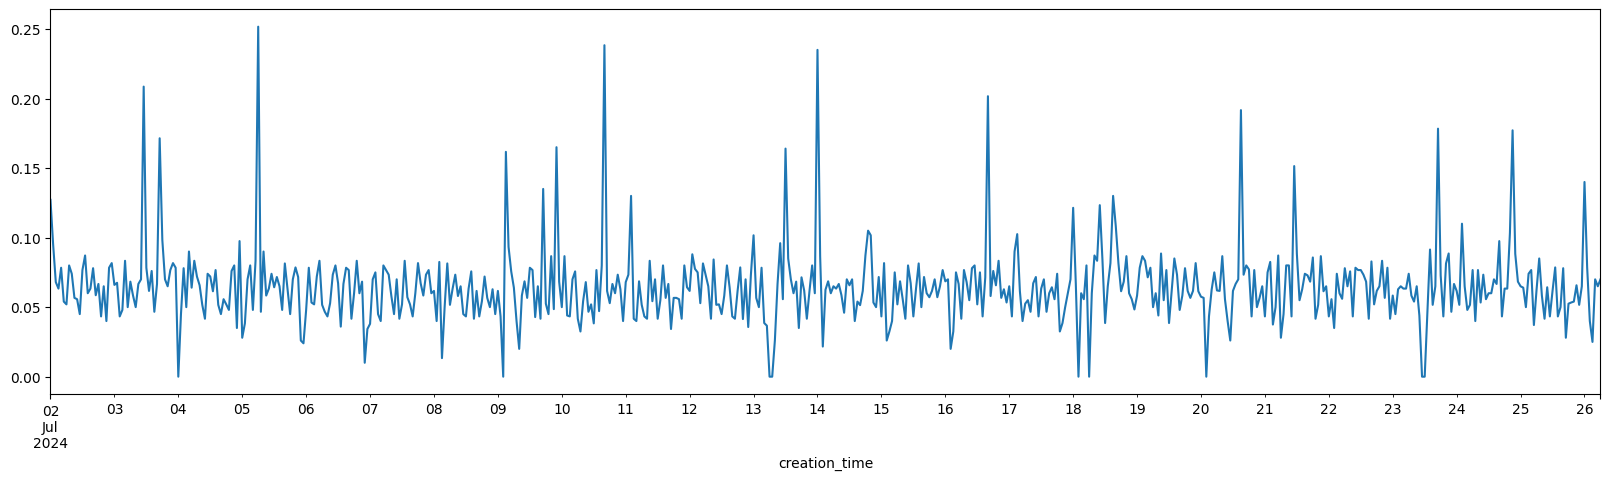

In [9]:
train_label.plot()

<Axes: xlabel='creation_time'>

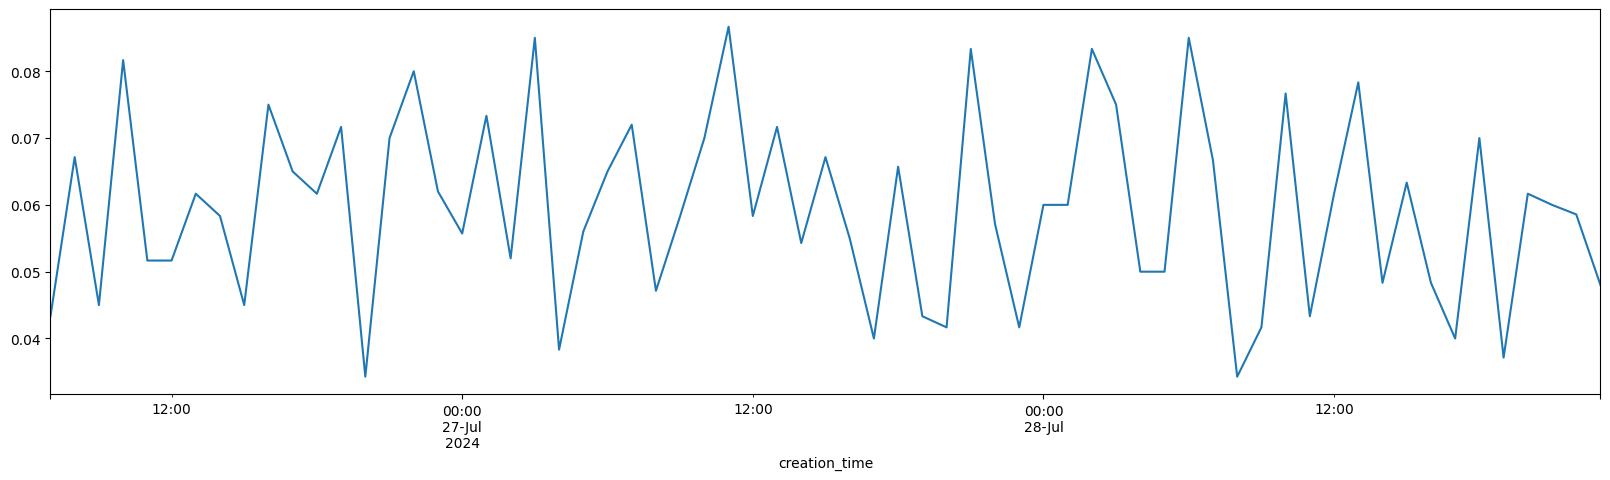

In [10]:
val_label.plot()

<Axes: xlabel='creation_time'>

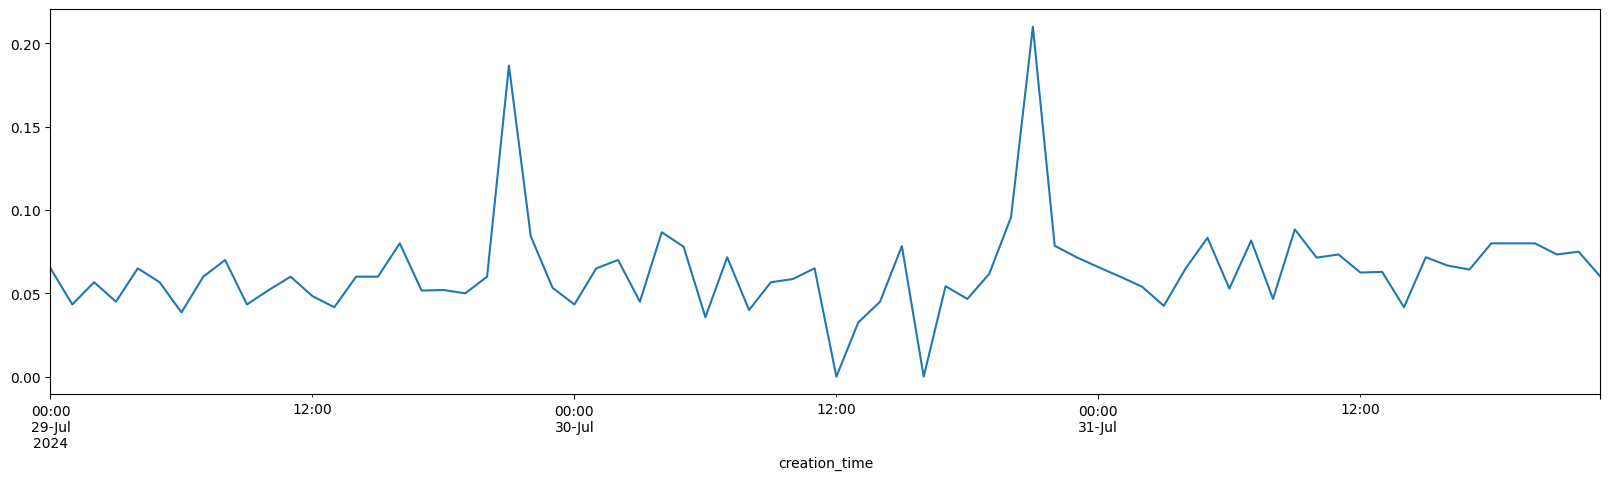

In [11]:
test_label.plot()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.5, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
TRAIN SCORE with hyperparameters tunning: 0.004225827123235271

Model Power Evaluation
Mean Absolute Error (MAE): 0.012502603444162305
Root Mean Squared Error (RMSE): 0.015015992212467912
R-squared: -0.16179943795938456


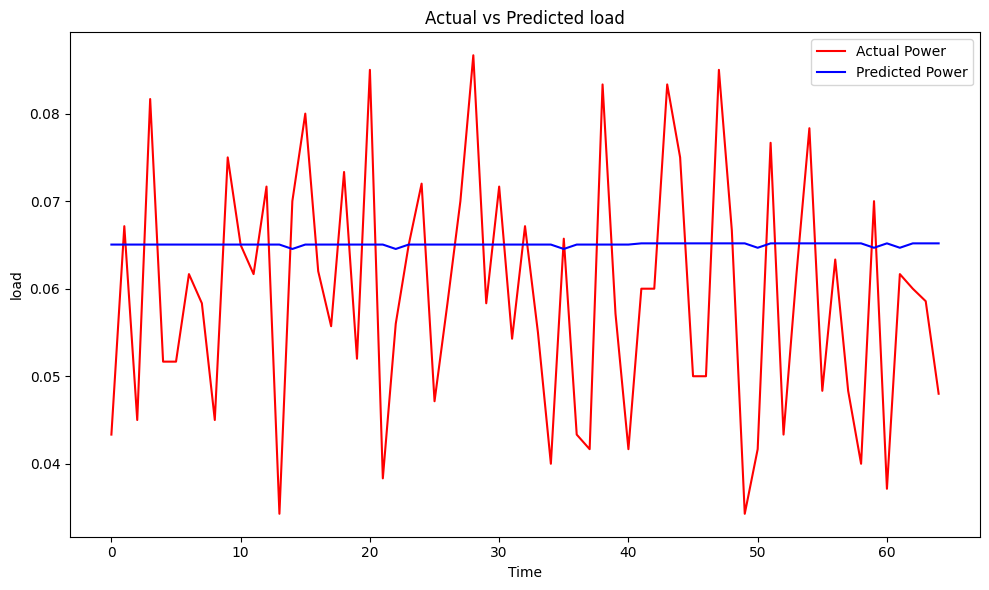


Model Power Evaluation
Mean Absolute Error (MAE): 0.016939920501773634
Root Mean Squared Error (RMSE): 0.028621524943443617
R-squared: 0.0014520218981297628


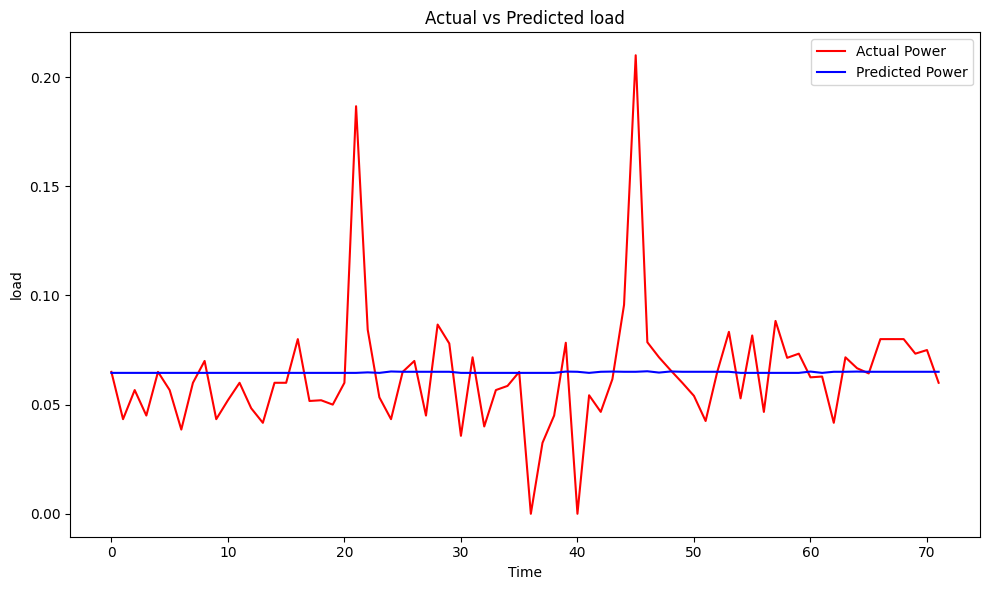

In [17]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize the model
xgb_model = XGBRegressor()

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'reg_alpha': [0.1, 1.0],
    'reg_lambda': [0.1, 1.0],
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=param_grid, 
                                   n_iter=20, 
                                   scoring='neg_mean_squared_error',
                                   cv=tscv, 
                                   verbose=1,
                                   random_state=42)

# Fit the random search on training data
random_search.fit(train_features, train_label)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train a new model with the best parameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(train_features, train_label)
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
# Evaluate on the validation set
plot_prediction(val_label, best_xgb_model.predict(val_features))
# plot_prediction(val_label, xgb_model.predict(val_features))
plot_prediction(test_label, best_xgb_model.predict(feature_scaler.transform(test_features)))


# # Calculate and print model evaluation metrics for this sensor
# train_score = xgb_model.score(train_features, train_label)
# print(f"Initial Train Score {train_score}")

# # Perform hyperparameter tuning using RandomizedSearchCV
# param_grid = {
#         "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
#         "max_depth": [ 10, 15, 20, 25, 30, 35, 40], # 1, 2, 3, 5,
#         "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
#         "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
#         "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
#         'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
#         'reg_lambda': [0.01, 0.1, 0.5, 1.0],  # Add L2 regularization

#     # 'n_estimators': [100, 200, 300, 400, 500],
#     # 'max_depth': [3, 5, 7, 10],
#     # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     # 'subsample': [0.5, 0.7, 0.8, 1.0],
#     # 'colsample_bytree': [0.5, 0.7, 1.0],
#     # 'reg_alpha': [0.01, 0.1, 0.5, 1.0]

#         # "n_estimators": [200, 250, 300, 350,400, 450, 500],
#         # "max_depth": [3,5,10,15, 20, 25,30],
#         # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
#         # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
#         # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
#         # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
#         }

# # random_search = RandomizedSearchCV(xgb_model,
# #                                     param_distributions=param_grid,
# #                                     n_iter=5,
# #                                     scoring='neg_mean_squared_error',
# #                                     cv=5,
# #                                     random_state=100)

# # # Fit the RandomizedSearchCV to the data
# # # random_search.fit(X_train, y_train)
# # random_search.fit(train_features, train_label)
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)
# random_search = RandomizedSearchCV(
#     estimator=xgb_model, 
#     param_distributions=param_grid, 
#     n_iter=10,
#     scoring='neg_mean_squared_error',
#     cv=tscv,  # Use time series split
#     verbose=1,
#     random_state=100
# )

# random_search.fit(train_features, train_label)


# # Get the best parameters
# best_params = random_search.best_params_
# print(f"Best Parameters: {best_params}")

# # Train the model with the best parameters
# best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
#                                 max_depth=best_params['max_depth'],
#                                 learning_rate=best_params['learning_rate'],
#                                 subsample=best_params['subsample'],
#                                 colsample_bytree=best_params['colsample_bytree'],
#                                 reg_alpha=best_params['reg_alpha'],
#                                 base_score=0.5,
#                                 booster='gbtree',
#                                 # reg_lambda=best_params['reg_lambda'],
#                                 objective='reg:squarederror')
# best_xgb_model.fit(train_features, train_label)

# # Evaluate the model on the test set
# test_score = best_xgb_model.score(train_features, train_label)
# print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

# best_xgb_model


location_id:217
null values :
Load_kW                     0
lag1_hour                 217
lag2_hours                434
lag3_hours                651
lag1_day                 5208
lag2_days               10416
lag3_days               15624
lag7_days               36456
hour                        0
day                         0
dayofweek                   0
weekofyear                  0
dayofyear                   0
is_weekend                  0
apparent_temperature        0
rain                        0
wind_speed_10m              0
location_id                 0
dtype: int64


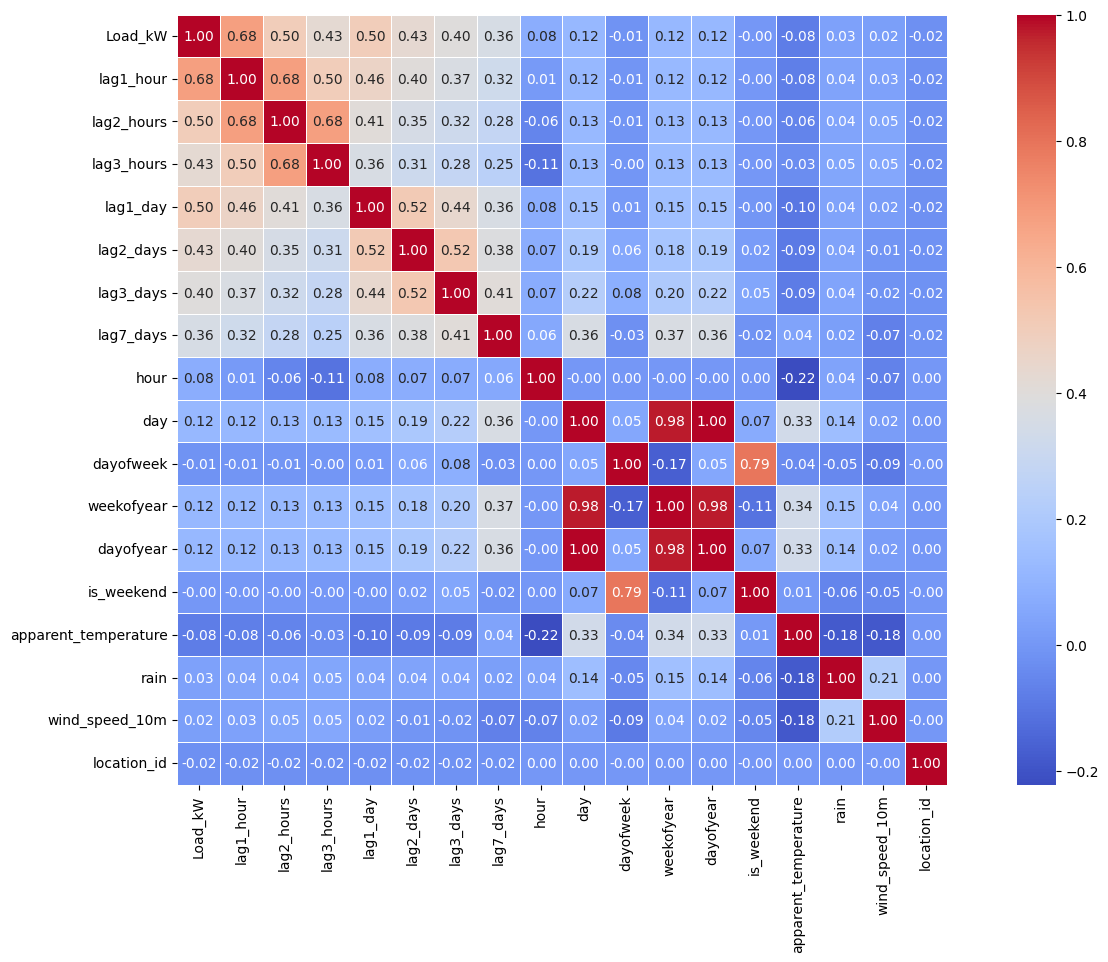

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag2_days,lag3_days,lag7_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.0617,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000010001
2024-07-01 00:00:00,1.6833,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000040103
2024-07-01 00:00:00,1.0650,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000011201
2024-07-01 00:00:00,0.7875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000040104
2024-07-01 00:00:00,1.1083,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000011106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.3520,0.7873,0.6130,0.6800,0.7500,0.9800,0.9590,0.3118,23,31,2,31,213,0,31.4000,1.7000,13.4000,100000021402
2024-07-31 23:00:00,1.3450,0.4800,1.0767,0.6033,0.7600,0.7686,0.4071,1.6250,23,31,2,31,213,0,31.4000,1.7000,13.4000,100000010805
2024-07-31 23:00:00,1.1000,0.4640,0.6680,0.4280,0.8122,0.4500,0.6487,1.2043,23,31,2,31,213,0,31.4000,1.7000,13.4000,100000030605


In [18]:
final_df = pd.concat(df_lst)
print(f"location_id:{final_df['location_id'].nunique()}")
print(f"null values :\n{final_df.isna().sum()}")
final_df.fillna(0, inplace=True)
final_df.sort_index(inplace=True)
common_obj.correlation_matrix(final_df)
final_df

In [ ]:
# ['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day','lag2_days', 'lag3_days', 'lag7_days', 'hour', 'day', 'dayofweek','weekofyear', 'dayofyear', 'is_weekend', 'apparent_temperature', 'rain','wind_speed_10m', 'location_id']
dff = final_df[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day','lag2_days', 'lag3_days', 'lag7_days', 'hour', 'day', 'dayofweek','weekofyear', 'dayofyear', 'is_weekend', 'apparent_temperature', 'rain','wind_speed_10m', 'location_id']]
# dff['Load_kW'] = dff['Load_kW'].rolling(window=4).mean()
# df3[['Load_kW','rolled_load']].plot()
# 
# dff.dropna(inplace=True)

In [21]:
n = len(final_df)
train_dataset, test_dataset = final_df[0:int(n*0.9)].copy(),final_df[int(n*0.9):].copy()
print(f"train_dataset,test_dataset: {train_dataset.shape,test_dataset.shape}")

train_dataset,test_dataset: ((144827, 18), (16092, 18))


In [22]:
train_dataset

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag2_days,lag3_days,lag7_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.0617,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000010001
2024-07-01 00:00:00,1.6833,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000040103
2024-07-01 00:00:00,1.0650,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000011201
2024-07-01 00:00:00,0.7875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000040104
2024-07-01 00:00:00,1.1083,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,30.4000,3.9000,9.8000,100000011106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28 21:00:00,0.7250,2.0237,1.3060,0.3650,2.0633,1.7590,1.5450,0.0830,21,28,6,30,210,1,35.0000,0.0000,7.6000,100000031106
2024-07-28 21:00:00,0.1767,0.2683,0.1260,0.0800,0.1517,0.2060,0.1420,0.5350,21,28,6,30,210,1,35.0000,0.0000,7.6000,100000040501
2024-07-28 21:00:00,0.8822,0.5440,0.7744,0.4410,0.6760,0.4529,1.1440,1.3470,21,28,6,30,210,1,35.0000,0.0000,7.6000,100000030606


In [32]:
train_features = train_dataset.copy()   
train_label = train_features.pop('Load_kW')
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

train_features shape: (144827, 14)
train_label shape: (144827,)


In [33]:
test_feature = test_dataset.copy()   
test_label = test_feature.pop('Load_kW')
print(f"test_feature shape: {test_feature.shape}\ntest_feature shape: {test_label.shape}")

test_feature shape: (16092, 14)
test_feature shape: (16092,)


In [34]:
target_variable = ["Load_kW"]
# Exclude the "Load_kW" column from features to normalize
features_to_normalize = [col for col in train_features.columns if col not in target_variable]
# print(features_to_normalize)

feature_scaler = MinMaxScaler()

train_features[features_to_normalize] = feature_scaler.fit_transform(train_features[features_to_normalize])



# Verify the scaling
print(f"train_features shape: {train_features.shape}")  # Should have the same shape as the original features
print(f"scaled input: {np.array(train_features[-2:-1:])}")
# # train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
def reshape_dataset(dataset):
    try:
        reshaped_df = np.array(dataset).reshape((dataset.shape[0], 1, dataset.shape[1]))
        return reshaped_df
    except Exception as e:
        print("error in reshape")

reshaped_train_features = reshape_dataset(train_features)
# reshaped_train_label = reshape_dataset(train_label)
print(f"reshaped_train_features:{reshaped_train_features.shape}")
train_features


train_features shape: (144827, 14)
scaled input: [[0.023705   0.0258372  0.02575359 0.13064091 0.01056146 0.91304348
  1.         1.         1.         1.         0.37313433 0.
  0.29707113 0.00056664]]
reshaped_train_features:(144827, 1, 14)


,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0299,0.2786,0.3891,0.0000
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0299,0.2786,0.3891,0.1672
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0299,0.2786,0.3891,0.0067
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0299,0.2786,0.3891,0.1672
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0299,0.2786,0.3891,0.0061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28 21:00:00,0.3554,0.2293,0.0641,0.3623,0.0170,0.9130,1.0000,1.0000,1.0000,1.0000,0.3731,0.0000,0.2971,0.1172
2024-07-28 21:00:00,0.0471,0.0221,0.0140,0.0266,0.1094,0.9130,1.0000,1.0000,1.0000,1.0000,0.3731,0.0000,0.2971,0.1694
2024-07-28 21:00:00,0.0955,0.1360,0.0774,0.1187,0.2753,0.9130,1.0000,1.0000,1.0000,1.0000,0.3731,0.0000,0.2971,0.1145


In [35]:
scaled_test_feature = feature_scaler.transform(test_feature)
print(scaled_test_feature)
# scaled_test_feature = pd.DataFrame(feature_scaler.transform(test_feature))
# scaled_test_feature.shape
print(f"reshaped_train_features: {scaled_test_feature.shape}\ntrain_label: {test_label.shape}")

[[0.29909277 0.1738367  0.01960784 ... 0.         0.29707113 0.00277762]
 [0.22159789 0.11700854 0.07761194 ... 0.         0.29707113 0.06223543]
 [0.10798946 0.17107739 0.33028973 ... 0.         0.29707113 0.11389367]
 ...
 [0.08147498 0.11729587 0.07515364 ... 0.12142857 0.53974895 0.11446031]
 [0.23617208 0.10736235 0.1666374  ... 0.12142857 0.53974895 0.1111216 ]
 [0.01755926 0.01755926 0.01755926 ... 0.12142857 0.53974895 1.        ]]
reshaped_train_features: (16092, 14)
train_label: (16092,)


In [18]:
print(len(reshaped_train_features))
n = len(reshaped_train_features)
train_df = reshaped_train_features[0:int(n*0.9)]
val_df = reshaped_train_features[int(n*0.9):]
train_f, val_f = train_df.copy(),val_df.copy()
print(f"train: {train_f.shape}\nval: {val_f.shape}")

144827
train: (130344, 1, 14)
val: (14483, 1, 14)


In [19]:
print(len(train_label))
n = len(train_label)
train_df2 = train_label[0:int(n*0.9)]
val_df2 = train_label[int(n*0.9):]
train_l, val_l = train_df2.copy(),val_df2.copy()
print(f"train: {train_l.shape}\nval: {val_l.shape}")

144827
train: (130344,)
val: (14483,)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam

# Define model
lstm_model = Sequential()

# Optionally add an embedding layer for location_id
# model.add(Embedding(input_dim=num_locations, output_dim=8, input_length=timesteps))

# LSTM layers
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])))

# model.add(LSTM(units=128, return_sequences=True, input_shape=reshaped_train_features.shape))

# model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, num_features)))
lstm_model.add(Dropout(0.2))  # Dropout to prevent overfitting
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.2))

# Dense output layer
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train the model
history = lstm_model.fit(train_f, np.array(train_l), epochs=20, batch_size=32,validation_data=(val_f, val_l))


Epoch 1/20
4074/4074 [==============================] - 24s 5ms/step - loss: 0.1735 - val_loss: 0.1510
Epoch 2/20
4074/4074 [==============================] - 22s 5ms/step - loss: 0.1326 - val_loss: 0.1444
Epoch 3/20
4074/4074 [==============================] - 37s 9ms/step - loss: 0.1288 - val_loss: 0.1414
Epoch 4/20
4074/4074 [==============================] - 42s 10ms/step - loss: 0.1271 - val_loss: 0.1414
Epoch 5/20
4074/4074 [==============================] - 35s 9ms/step - loss: 0.1259 - val_loss: 0.1400
Epoch 6/20
4074/4074 [==============================] - 19s 5ms/step - loss: 0.1252 - val_loss: 0.1394
Epoch 7/20
4074/4074 [==============================] - 19s 5ms/step - loss: 0.1247 - val_loss: 0.1393
Epoch 8/20
4074/4074 [==============================] - 19s 5ms/step - loss: 0.1246 - val_loss: 0.1390
Epoch 9/20
4074/4074 [==============================] - 20s 5ms/step - loss: 0.1244 - val_loss: 0.1390
Epoch 10/20
4074/4074 [==============================] - 18s 4ms/step - 

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_f, np.array(train_l), epochs=20, batch_size=32, validation_data=(val_f, val_l))


Epoch 1/20
4074/4074 [==============================] - 33s 7ms/step - loss: 0.1308 - val_loss: 0.1457
Epoch 2/20
4074/4074 [==============================] - 29s 7ms/step - loss: 0.1245 - val_loss: 0.1415
Epoch 3/20
4074/4074 [==============================] - 30s 7ms/step - loss: 0.1232 - val_loss: 0.1384
Epoch 4/20
4074/4074 [==============================] - 31s 8ms/step - loss: 0.1217 - val_loss: 0.1411
Epoch 5/20
4074/4074 [==============================] - 32s 8ms/step - loss: 0.1210 - val_loss: 0.1372
Epoch 6/20
4074/4074 [==============================] - 31s 8ms/step - loss: 0.1204 - val_loss: 0.1376
Epoch 7/20
4074/4074 [==============================] - 31s 8ms/step - loss: 0.1199 - val_loss: 0.1385
Epoch 8/20
4074/4074 [==============================] - 29s 7ms/step - loss: 0.1197 - val_loss: 0.1380
Epoch 9/20
4074/4074 [==============================] - 37s 9ms/step - loss: 0.1192 - val_loss: 0.1369
Epoch 10/20
4074/4074 [==============================] - 51s 12ms/step - 

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [40]:
test_dataset['location_id'].unique()

array([100000010501, 100000021204, 100000030503, 100000021102,
       100000040601, 100000040902, 100000030704, 100000030601,
       100000021201, 100000040704, 100000030301, 100000021701,
       100000020906, 100000020201, 100000040303, 100000040304,
       100000020205, 100000030205, 100000020601, 100000031004,
       100000010306, 100000030806, 100000030101, 100000040301,
       100000031202, 100000031101, 100000041106, 100000020203,
       100000020404, 100000040805, 100000020606, 100000040405,
       100000040003, 100000030901, 100000031806, 100000010205,
       100000020403, 100000020003, 100000020306, 100000041402,
       100000020006, 100000031904, 100000031702, 100000011405,
       100000040104, 100000011401, 100000021802, 100000021103,
       100000021703, 100000040103, 100000031201, 100000020904,
       100000030102, 100000010502, 100000020303, 100000040705,
       100000031105, 100000030706, 100000020705, 100000020204,
       100000020104, 100000020406, 100000041205, 100000

scaled input: [0.11014446 0.12941176 0.1046532  0.14468832 0.1161451  1.
 1.11111111 1.33333333 0.33333333 0.         0.10447761 0.12142857
 0.53974895 0.06224099]
input shape: (75, 1, 14)
3/3 [==============================] - 0s 3ms/step

Model Power Evaluation
Mean Squared Error (MSE): 0.2935829761414106
Mean Absolute Error (MAE): 0.4283760384607291
Root Mean Squared Error (RMSE): 0.5418329780858772
R-squared: 0.02789732493162622


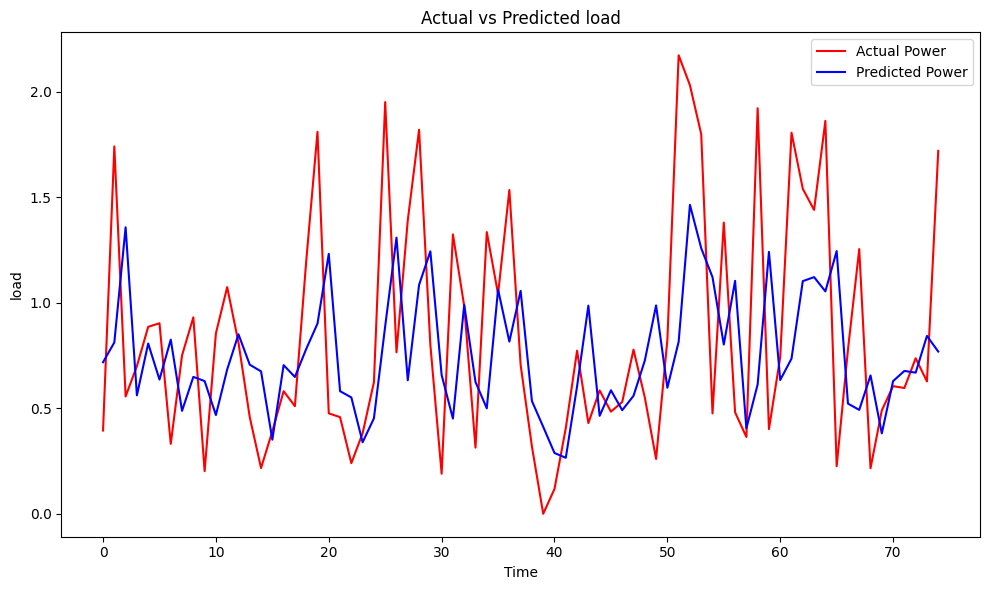

In [55]:
t = test_dataset[test_dataset['location_id']==100000021205]  # 100000041103
test_feature = t.copy()
# test_feature = test_dataset.copy()
test_label = test_feature.pop('Load_kW')

def lstm_prediction(model_name, scaler, input_data, input_label = None):
    # scale
    scaled_input = scaler.transform(input_data)
    print(f"scaled input: {scaled_input[-1]}")
    # reshape
    reshaped_scaled_input = np.array(scaled_input).reshape((scaled_input.shape[0], 1, scaled_input.shape[1]))
    print(f"input shape: {reshaped_scaled_input.shape}")
    y_pred = model_name.predict(reshaped_scaled_input)
    plot_prediction(input_label,y_pred)
    return y_pred
pred = lstm_prediction(lstm_model,feature_scaler,test_feature,test_label)

In [36]:
test_feature

,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,,,
2024-07-28 21:00:00,1.7033,0.9900,0.1117,0.0467,0.0483,21,28,30,6,1,35.0000,0.0000,7.6000,100000010501
2024-07-28 21:00:00,1.2620,0.6664,0.4420,2.0150,1.0100,21,28,30,6,1,35.0000,0.0000,7.6000,100000021204
2024-07-28 21:00:00,0.6150,0.9743,1.8810,1.8725,0.2380,21,28,30,6,1,35.0000,0.0000,7.6000,100000030503
2024-07-28 21:00:00,0.6471,0.8143,0.6000,0.7313,0.2450,21,28,30,6,1,35.0000,0.0000,7.6000,100000021102
2024-07-28 21:00:00,0.3933,0.7200,2.2133,1.0114,0.9617,21,28,30,6,1,35.0000,0.0000,7.6000,100000040601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.7873,0.6130,0.6800,0.7500,0.3118,23,31,31,2,0,31.4000,1.7000,13.4000,100000021402
2024-07-31 23:00:00,0.4800,1.0767,0.6033,0.7600,1.6250,23,31,31,2,0,31.4000,1.7000,13.4000,100000010805
2024-07-31 23:00:00,0.4640,0.6680,0.4280,0.8122,1.2043,23,31,31,2,0,31.4000,1.7000,13.4000,100000030605


In [37]:
# np.set_printoptions(suppress=True, precision=8)

feature_scaler.transform(test_feature)

array([[0.29909277, 0.1738367 , 0.01960784, ..., 0.        , 0.29707113,
        0.00277762],
       [0.22159789, 0.11700854, 0.07761194, ..., 0.        , 0.29707113,
        0.06223543],
       [0.10798946, 0.17107739, 0.33028973, ..., 0.        , 0.29707113,
        0.11389367],
       ...,
       [0.08147498, 0.11729587, 0.07515364, ..., 0.12142857, 0.53974895,
        0.11446031],
       [0.23617208, 0.10736235, 0.1666374 , ..., 0.12142857, 0.53974895,
        0.1111216 ],
       [0.01755926, 0.01755926, 0.01755926, ..., 0.12142857, 0.53974895,
        1.        ]])

In [43]:
test_feature

,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,,,
2024-07-28 21:00:00,1.7033,0.9900,0.1117,0.0467,0.0483,21,28,30,6,1,35.0000,0.0000,7.6000,100000010501
2024-07-28 21:00:00,1.2620,0.6664,0.4420,2.0150,1.0100,21,28,30,6,1,35.0000,0.0000,7.6000,100000021204
2024-07-28 21:00:00,0.6150,0.9743,1.8810,1.8725,0.2380,21,28,30,6,1,35.0000,0.0000,7.6000,100000030503
2024-07-28 21:00:00,0.6471,0.8143,0.6000,0.7313,0.2450,21,28,30,6,1,35.0000,0.0000,7.6000,100000021102
2024-07-28 21:00:00,0.3933,0.7200,2.2133,1.0114,0.9617,21,28,30,6,1,35.0000,0.0000,7.6000,100000040601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.7873,0.6130,0.6800,0.7500,0.3118,23,31,31,2,0,31.4000,1.7000,13.4000,100000021402
2024-07-31 23:00:00,0.4800,1.0767,0.6033,0.7600,1.6250,23,31,31,2,0,31.4000,1.7000,13.4000,100000010805
2024-07-31 23:00:00,0.4640,0.6680,0.4280,0.8122,1.2043,23,31,31,2,0,31.4000,1.7000,13.4000,100000030605


In [45]:
len(pred)

16092

In [46]:
pred_df = test_feature.copy()
pred_df['pred'] = pred
pred_df

,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,apparent_temperature,rain,wind_speed_10m,location_id,pred
creation_time,,,,,,,,,,,,,,,
2024-07-28 21:00:00,1.7033,0.9900,0.1117,0.0467,0.0483,21,28,30,6,1,35.0000,0.0000,7.6000,100000010501,1.0965
2024-07-28 21:00:00,1.2620,0.6664,0.4420,2.0150,1.0100,21,28,30,6,1,35.0000,0.0000,7.6000,100000021204,1.3655
2024-07-28 21:00:00,0.6150,0.9743,1.8810,1.8725,0.2380,21,28,30,6,1,35.0000,0.0000,7.6000,100000030503,1.0093
2024-07-28 21:00:00,0.6471,0.8143,0.6000,0.7313,0.2450,21,28,30,6,1,35.0000,0.0000,7.6000,100000021102,0.7201
2024-07-28 21:00:00,0.3933,0.7200,2.2133,1.0114,0.9617,21,28,30,6,1,35.0000,0.0000,7.6000,100000040601,0.8282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.7873,0.6130,0.6800,0.7500,0.3118,23,31,31,2,0,31.4000,1.7000,13.4000,100000021402,0.8144
2024-07-31 23:00:00,0.4800,1.0767,0.6033,0.7600,1.6250,23,31,31,2,0,31.4000,1.7000,13.4000,100000010805,0.8013
2024-07-31 23:00:00,0.4640,0.6680,0.4280,0.8122,1.2043,23,31,31,2,0,31.4000,1.7000,13.4000,100000030605,0.7451


In [50]:

pred_df[pred_df['pred']<0]['location_id'].unique()

array([100000020203, 100000030301, 100000040902, 100000010206,
       100000031002, 100000021606, 100000030401, 100000040202,
       100000021806, 100000040204, 100000021703, 100000040805,
       100000010004, 100000031601, 100000020503, 100000010001,
       100000040301, 100000040905, 100000021501, 100000040703,
       100000030603, 100000031904, 100000030105, 100000010103,
       100000020602, 100000021106, 100000040405, 100000020006,
       100000030405, 100000021003, 100000031901, 100000020604,
       100000040003, 100000011204, 100000040501, 100000020803,
       100000040006, 100000041001, 100000030102, 100000031106,
       100000040101, 100000030205, 100000030506, 100000010306,
       100000031604, 100000021001, 100000020103, 100000021604,
       100000040505, 100000041004, 100000030901, 100000021102,
       100000030006, 100000031703, 100000020605, 100000020305,
       100000020205, 100000020206, 100000020005, 100000031706,
       100000031603, 100000021201, 100000021504, 100000